# Preprocessing for regresssion  model to detect bounding box of a house number
This notebook loads the SVN format 1 data sets with bounding boxes and calculates an overall bounding box for the house number and then rescale the image to a size of 224x224 pixels (gray scale) and rescale the bounding box as well. 

# Introduction
We are using the "The Street View House Numbers (SVHN) Datase" by Stanford University. The following informations are copied from the website http://ufldl.stanford.edu/housenumbers/ to produce an self-contained document.

## The Street View House Numbers (SVHN) Dataset 


SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

### Overview
- 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.
- 73257 digits for training, 26032 digits for testing, and 531131 additional, somewhat less difficult samples, to use as extra training data
- Comes in two formats:
    1. Original images with character level bounding boxes.
    2. MNIST-like 32-by-32 images centered around a single character (many of the images do contain some distractors at the sides).
    
### Downloads

- Format 1: Full Numbers: train.tar.gz, test.tar.gz , extra.tar.gz (Note: for non-commercial use only)

![alt text](http://ufldl.stanford.edu/housenumbers/examples_new.png)

These are the original, variable-resolution, color house-number images with character level bounding boxes, as shown in the examples images above. (The blue bounding boxes here are just for illustration purposes. The bounding box information are stored in digitStruct.mat instead of drawn directly on the images in the dataset.) Each tar.gz file contains the orignal images in png format, together with a digitStruct.mat file, which can be loaded using Matlab. The digitStruct.mat file contains a struct called digitStruct with the same length as the number of original images. Each element in digitStruct has the following fields: name which is a string containing the filename of the corresponding image. bbox which is a struct array that contains the position, size and label of each digit bounding box in the image. Eg: digitStruct(300).bbox(2).height gives height of the 2nd digit bounding box in the 300th image. 

- Format 2: Cropped Digits: train_32x32.mat, test_32x32.mat , extra_32x32.mat (Note: for non-commercial use only) 

![alt text](http://ufldl.stanford.edu/housenumbers/32x32eg.png)

Character level ground truth in an MNIST-like format. All digits have been resized to a fixed resolution of 32-by-32 pixels. The original character bounding boxes are extended in the appropriate dimension to become square windows, so that resizing them to 32-by-32 pixels does not introduce aspect ratio distortions. Nevertheless this preprocessing introduces some distracting digits to the sides of the digit of interest. Loading the .mat files creates 2 variables: X which is a 4-D matrix containing the images, and y which is a vector of class labels. To access the images, X(:,:,:,i) gives the i-th 32-by-32 RGB image, with class label y(i).

### Reference
Please cite the following reference in papers using this dataset:

Yuval Netzer, Tao Wang, Adam Coates, Alessandro Bissacco, Bo Wu, Andrew Y. Ng Reading Digits in Natural Images with Unsupervised Feature Learning NIPS Workshop on Deep Learning and Unsupervised Feature Learning 2011. (PDF)
Please use http://ufldl.stanford.edu/housenumbers as the URL for this site when necessary

For questions regarding the dataset, please contact streetviewhousenumbers@gmail.com



 ## Important: I will use the format 1 - full numbers.

The reason is, that this will allows not only to train a classifier for house number recognition but also a regression model to find the bounding boxes of a full house number on an image using the full house-number images together with the character level bounding boxes (this bounding boxes will be replaced during preprocessing with one bounding box for the full house number)

## Import all required modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import sys
import tarfile
import h5py
from __future__ import print_function
from six.moves import cPickle as pickle
from six.moves import range
from six.moves.urllib.request import urlretrieve
from IPython.display import display, Image
from scipy import ndimage
import numpy as np

# Get the Data
## Download the train, test and extra dataset

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
def download(filename, force=False):
  """Download a file if not present, and check that it's has the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  return filename

trainFilename = download('train.tar.gz')
testFilename = download('test.tar.gz')
extraFilename = download('extra.tar.gz')

print("Loading done")

Loading done


## Extract data files

In [3]:
def extractFiles(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  dataFolders = root
  print(dataFolders)
  return dataFolders
  
trainFolder = extractFiles(trainFilename)
testFolder = extractFiles(testFilename)
extraFolder = extractFiles(extraFilename)
print ("Extracting done")

train already present - Skipping extraction of train.tar.gz.
train
test already present - Skipping extraction of test.tar.gz.
test
extra already present - Skipping extraction of extra.tar.gz.
extra
Extracting done


# Preprocessing
## Load and process bounding boxes and filenames from digitStruct file

The bounding box information are stored in digitStruct.mat instead of drawn directly on the images in the dataset.) Each tar.gz file contains the orignal images in png format, together with a digitStruct.mat file, which can be loaded using Matlab. The digitStruct.mat file contains a struct called digitStruct with the same length as the number of original images. Each element in digitStruct has the following fields: name which is a string containing the filename of the corresponding image. bbox which is a struct array that contains the position, size and label of each digit bounding box in the image. Eg: digitStruct(300).bbox(2).height gives height of the 2nd digit bounding box in the 300th image. 



In [4]:
#Helper Methods to read attributes of digitStruct.mat and imagesize of images
from PIL import Image

def getPictureName(digitStruct,index):
    x=digitstruct[digitstruct['digitStruct']['name'][index][0]].value.tostring()
    name="".join(map(chr, x)).replace("\x00", "")
  #  return digitStruct[digitStruct['digitStruct']['name'][index][0]].value.tostring().replace("\x00", "")
    return name

def getBBoxAttr(digitstruct, index, attr):
    attribute = digitstruct[digitstruct['digitStruct']['bbox'][index][0]][attr].value.squeeze()
    if attribute.dtype == 'float64':
        return attribute.reshape(-1)
    else:
        return np.array([digitstruct[x].value for x in attribute]).squeeze()

def getBBox(digitstruct,index):
    bbox = {}
    bbox['height'] = getBBoxAttr(digitstruct, index,'height')
    bbox['label'] = getBBoxAttr(digitstruct, index,'label')
    bbox['left'] = getBBoxAttr(digitstruct, index,'left')
    bbox['top'] = getBBoxAttr(digitstruct, index,'top')
    bbox['width'] = getBBoxAttr(digitstruct, index,'width')
    return bbox
    
def getImageInfo(folder,digitstruct,index):
    info=getBBox(digitstruct,index)
    n=getPictureName(digitstruct,index)
    info['name']=getPictureName(digitstruct,index)
    fullname = os.path.join(folder, info['name'])
    im = Image.open(fullname)
    info['imgwidth']=im.size[0]
    info['imgheight']=im.size[1]
    return info
   
def getAllImageInfos(folder):
    digitstruct=h5py.File(os.path.join(folder,'digitStruct.mat'),'r')
    print(len(digitstruct['digitStruct']['name']))
    return [getImageInfo(folder,digitstruct,i) for i in range(len(digitstruct['digitStruct']['name']))]
 

In [5]:
f=os.path.join('train','digitStruct.mat')
digitstruct=h5py.File(f, 'r')
getImageInfo("train",digitstruct,0)


{'height': array([ 219.,  219.]),
 'imgheight': 350,
 'imgwidth': 741,
 'label': array([ 1.,  9.]),
 'left': array([ 246.,  323.]),
 'name': '1.png',
 'top': array([ 77.,  81.]),
 'width': array([ 81.,  96.])}

In [6]:
f=os.path.join('extra','digitStruct.mat')
digitstruct=h5py.File(f, 'r')
getImageInfo("extra",digitstruct,35000)

{'height': array([ 75.]),
 'imgheight': 90,
 'imgwidth': 83,
 'label': array([ 9.]),
 'left': array([ 13.]),
 'name': '35001.png',
 'top': array([ 2.]),
 'width': array([ 54.])}

In [7]:
trainInfos=getAllImageInfos(trainFolder)
print ("Train image infos collected")
testInfos=getAllImageInfos(testFolder)
print ("Test image infos collected")
extraInfos=getAllImageInfos(extraFolder)
print ("Extra image infos collected")

33402
Train image infos collected
13068
Test image infos collected
202353
Extra image infos collected


In [8]:
print(trainInfos[0])
print(testInfos[1])
print(extraInfos[2])


{'left': array([ 246.,  323.]), 'width': array([ 81.,  96.]), 'imgheight': 350, 'label': array([ 1.,  9.]), 'height': array([ 219.,  219.]), 'top': array([ 77.,  81.]), 'name': '1.png', 'imgwidth': 741}
{'left': array([  99.,  114.,  121.]), 'width': array([ 14.,   8.,  12.]), 'imgheight': 48, 'label': array([  2.,   1.,  10.]), 'height': array([ 23.,  23.,  23.]), 'top': array([ 5.,  8.,  6.]), 'name': '2.png', 'imgwidth': 182}
{'left': array([ 18.,  40.,  72.]), 'width': array([ 20.,  33.,  34.]), 'imgheight': 96, 'label': array([ 1.,  7.,  4.]), 'height': array([ 63.,  63.,  63.]), 'top': array([  5.,   6.,  18.]), 'name': '3.png', 'imgwidth': 137}


In [9]:
trainInfos[29929]['label']

array([ 1.,  3.,  5.,  4.,  5.,  8.])

## Calculate overall bounding box around the housenumber and joining single numbers to multidigit housenumber

In [10]:
import PIL.Image as Image
imgsize=32

def imageAndBoundingBox(imgInfos,folder,ind,new_height,new_width,debug=False):
    filename = imgInfos[ind]['name']
    fullname = os.path.join(folder, filename)
    img = Image.open(fullname)

    # image size
    imgwidth= imgInfos[ind]['imgwidth']
    imgheight=imgInfos[ind]['imgheight']
    #coordinates of bounding boxes
    top=imgInfos[ind]['top']
    height=imgInfos[ind]['height']
    left=imgInfos[ind]['left']
    width=imgInfos[ind]['width']
    #calculate bounding box around all digits 
    #bounding box shall be little bit larger and shall preserve image proportions
    im_top = np.amin(top)
    im_left = np.amin(left)
    im_height = np.amax(top) + height[np.argmax(top)] - im_top
    im_width = np.amax(left) + width[np.argmax(left)] - im_left    
    im_top = max(0,int(np.floor(im_top - 0.1 * im_height)))
    im_left = max(0,int(np.floor(im_left - 0.1 * im_width)))
    im_bottom = min(imgheight,int(np.floor(np.amin([np.ceil(im_top + 1.2 * im_height), img.size[1]]))))
    im_right = min(imgwidth,int(np.floor(np.amin([np.ceil(im_left + 1.2 * im_width), img.size[0]]))))
    
    if debug:
        print("bounding box",im_left, im_top,im_right,im_bottom)
    
    #resize image and bounding box
    img_r = img.resize((new_width, new_height),Image.ANTIALIAS)
    factor_h=1.0*new_height/imgheight
    factor_w=1.0*new_width/imgwidth
    
    im_top_r=int(im_top*factor_h)
    im_bottom_r=int(im_bottom*factor_h)
    im_left_r=int(im_left*factor_w)
    im_right_r=int(im_right*factor_w)
     
    if debug:    
        print("resized bounding box",im_left_r, im_top_r,im_right_r,im_bottom_r)
    # pack upper left and lower right corners in a list
    bbox_r= [im_left_r, im_top_r,im_right_r,im_bottom_r]
    if debug:
        fig,ax = plt.subplots(1)
        ax.imshow(img)
        rect = patches.Rectangle((im_left,im_top),im_right-im_left,im_bottom-im_top,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        fig,ax = plt.subplots(1)
        ax.imshow(img_r)
        rect = patches.Rectangle((im_left_r,im_top_r),im_right_r-im_left_r,im_bottom_r-im_top_r,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        imcrop = img.crop((im_left, im_top, im_right, im_bottom)).resize([imgsize,imgsize], Image.ANTIALIAS)

        fig,ax = plt.subplots(1)
        ax.imshow(imcrop)


        imcrop = img_r.crop((im_left_r, im_top_r, im_right_r, im_bottom_r)).resize([imgsize,imgsize], Image.ANTIALIAS)

        fig,ax = plt.subplots(1)
        ax.imshow(imcrop)
    return img_r,bbox_r

bounding box 21 3 72 49
resized bounding box 25 6 86 114
[25, 6, 86, 114]


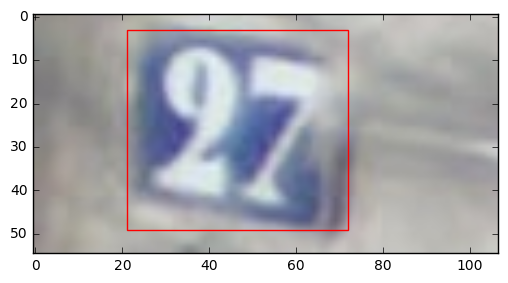

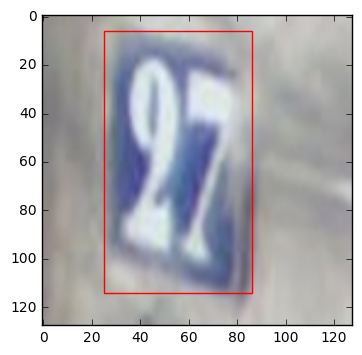

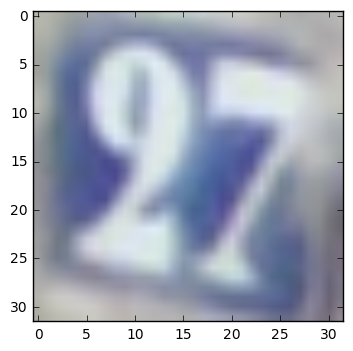

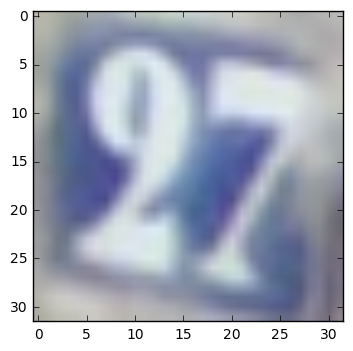

In [11]:
img,bbox=imageAndBoundingBox(trainInfos,trainFolder,9007,128,128,debug=True)
print(bbox)

In [12]:
img_height=128
img_width=128
def createDatasets(imgInfos, folder):
    print (len(imgInfos))
    datasetGray = np.ndarray([len(imgInfos),img_height,img_width,1], dtype='float32')
    bboxes = np.zeros([len(imgInfos),4], dtype=int)
    labels = np.ones([len(imgInfos),6], dtype=int) * 10
    
    for i in np.arange(len(imgInfos)):
        num_digit = len(imgInfos[i]['label'])
        labels[i,0] = num_digit
        for j in np.arange(num_digit):
            if j < 5: 
                labels[i,j+1] = imgInfos[i]['label'][j]
                if imgInfos[i]['label'][j] == 10: labels[i,j+1] = 0
            else: print('#',i,'image has more than 5 digits.')
        img,bbox=imageAndBoundingBox(imgInfos,folder,i,img_height,img_width,debug=False)
        for j in range(0,4):
            bboxes[i,j]=bbox[j]
        imGray = np.dot(np.array(img, dtype='float32'), [[0.2989],[0.5870],[0.1140]])  ##grayscale
        datasetGray[i,:,:,:] = imGray[:,:,:]   
    print("createDataSet done")    
    return datasetGray,bboxes,labels

In [13]:
trainDatasetGray, trainBoundingBoxes,trainLabels=createDatasets(trainInfos,trainFolder)
testDatasetGray, testBoundingBoxes,testLabels=createDatasets(testInfos,testFolder)
extraDatasetGray, extraBoundingBoxes,extraLabels=createDatasets(extraInfos,extraFolder)

33402
# 29929 image has more than 5 digits.
createDataSet done
13068
createDataSet done
202353
createDataSet done


[ 25   6  86 114]
[ 2  2  7 10 10 10]


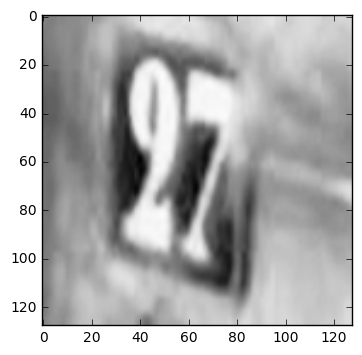

In [14]:
print(trainBoundingBoxes[9007])
print(trainLabels[9007])
fig,ax = plt.subplots(1)
ax.imshow(trainDatasetGray[9007,:,:,0], cmap="Greys_r")

## Remove data set with more than 5 digits

In [15]:
trainDatasetGray = np.delete(trainDatasetGray, 29929, axis=0)
trainBoundingBoxes = np.delete(trainBoundingBoxes, 29929, axis=0)
trainLabels = np.delete(trainLabels, 29929, axis=0)

## Distribute extra dataset to train data set and validate data set

Following Sermanet et al. (2012), to build a validation set, we select 400 samples per class from the training set and 200 samples per class from the extra set. The remaining digits of the train and extra sets are used for training.

Reference:

Sermanet, Pierre, Chintala, Soumith, and LeCun, Yann. Convolutional neural networks applied to house numbers digit classification. In International Conference on Pattern Recognition (ICPR 2012), 2012

#import note: at this stage we need at least 45GB RAM


In [16]:
import random

random.seed()


n_labels = 10
validIndex = []
validIndex2 = []
trainIndex = []
trainIndex2 = []
for i in np.arange(n_labels):
    validIndex.extend(np.where(trainLabels[:,1] == (i))[0][:400].tolist())
    trainIndex.extend(np.where(trainLabels[:,1] == (i))[0][400:].tolist())
    validIndex2.extend(np.where(extraLabels[:,1] == (i))[0][:200].tolist())
    trainIndex2.extend(np.where(extraLabels[:,1] == (i))[0][200:].tolist())

random.shuffle(validIndex)
random.shuffle(trainIndex)
random.shuffle(validIndex2)
random.shuffle(trainIndex2)

validBoundingBoxes = np.concatenate((extraBoundingBoxes[validIndex2,:], trainBoundingBoxes[validIndex,:]), axis=0)
trainBoundingBoxes_t = np.concatenate((extraBoundingBoxes[trainIndex2,:], trainBoundingBoxes[trainIndex,:]), axis=0)

validLabels = np.concatenate((extraLabels[validIndex2,:], trainLabels[validIndex,:]), axis=0)
trainLabels_t = np.concatenate((extraLabels[trainIndex2,:], trainLabels[trainIndex,:]), axis=0)

validDatasetGray = np.concatenate((extraDatasetGray[validIndex2,:,:,:], trainDatasetGray[validIndex,:,:,:]), axis=0)
trainDatasetGray_t = np.concatenate((extraDatasetGray[trainIndex2,:,:,:], trainDatasetGray[trainIndex,:,:,:]), axis=0)


print(trainDatasetGray_t.shape, trainBoundingBoxes_t.shape)
print(testDatasetGray.shape, testBoundingBoxes.shape)
print(validDatasetGray.shape, validBoundingBoxes.shape)

(230070, 128, 128, 1) (230070, 4)
(13068, 128, 128, 1) (13068, 4)
(5684, 128, 128, 1) (5684, 4)


[  8  18 104 117]
[57 37 70 90]
[ 50  17  80 113]
[  8  18 104 117]
[ 3  4  0  3 10 10]


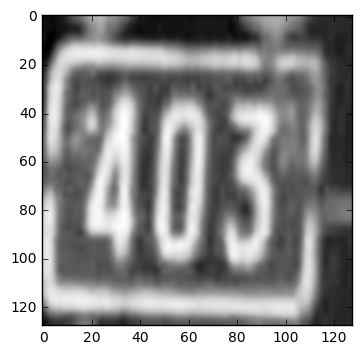

In [19]:
print(trainBoundingBoxes_t[9007])
print(testBoundingBoxes[12000])
print(validBoundingBoxes[315])
print(trainBoundingBoxes_t[9007])
print(trainLabels_t[9007])
fig,ax = plt.subplots(1)
ax.imshow(trainDatasetGray_t[9007,:,:,0], cmap="Greys_r")

In [18]:
#import note: a file of 16GB size will be written!
with h5py.File("SVHN_multin_bboxes.hdf5", "w") as hf:
    hf.create_dataset('train_dataset', data=trainDatasetGray_t)
    hf.create_dataset('train_boundingboxes', data=trainBoundingBoxes_t)
    hf.create_dataset('train_labels', data=trainLabels_t)
    hf.create_dataset('valid_dataset', data=validDatasetGray)
    hf.create_dataset('valid_boundingboxes', data=validBoundingBoxes)
    hf.create_dataset('valid_labels', data=validLabels)
    hf.create_dataset('test_dataset', data=testDatasetGray)
    hf.create_dataset('test_boundingboxes', data=testBoundingBoxes)
    hf.create_dataset('test_labels', data=testLabels)
print("Images and bounding boxes and labels saved")    

Images and bounding boxes and labels saved
